In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

from Arwin.dataset.synthetic_dataset import SyntheticDataset
from Arwin.model.trainer import Trainer
from Arwin.model.deeponet import *

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 500: named symbol not found (Triggered internally at /opt/pytorch/pytorch/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
synthetic_dataset = SyntheticDataset(100000, 128, padding=False, verbose=True)

Sampling Functions from Beta Distribution 1/3 with a=2, b=5: 100%|██████████| 33333/33333 [01:53<00:00, 293.36it/s]
Sampling Functions from Beta Distribution 2/3 with a=3, b=3: 100%|██████████| 33333/33333 [01:46<00:00, 313.32it/s]
Sampling Functions from Beta Distribution 3/3 with a=5, b=2: 100%|██████████| 33334/33334 [01:47<00:00, 311.51it/s]
Generating Observations: 100%|██████████| 100000/100000 [00:07<00:00, 13508.47it/s]


[-2.15035028 -2.04386119 -1.93700225 -1.82989286 -1.72265612 -1.61541823
 -1.50830777 -1.40145618 -1.29499655 -1.18906442 -1.08379413 -0.97932509
 -0.87579237 -0.77333377 -0.67208549 -0.57218301 -0.47376033 -0.37694924
 -0.28187997 -0.18867889 -0.09747018 -0.00837415  0.07849316  0.16302006
  0.24509921  0.32462853  0.40151085  0.47565566  0.54697717  0.61539695
  0.68084235  0.74324762  0.80255344  0.85870765  0.91166504  0.96138793
  1.00784566  1.05101505  1.09087915  1.12742903  1.16066362  1.19058792
  1.21721382  1.24056071  1.26065404  1.27752686  1.29121747  1.30177001
  1.30923548  1.31366998  1.3151347   1.31369519  1.30942302  1.30239302
  1.29268431  1.28037978  1.26556535  1.24832861  1.2287625   1.20695851
  1.18301396  1.15702362  1.12908484  1.09929755  1.06775826  1.03456659
  0.99982014  0.9636163   0.9260515   0.88722098  0.84721737  0.80613331
  0.7640585   0.72107948  0.67728151  0.63274718  0.58755582  0.54178372
  0.49550493  0.4487896   0.40170442  0.35431444  0

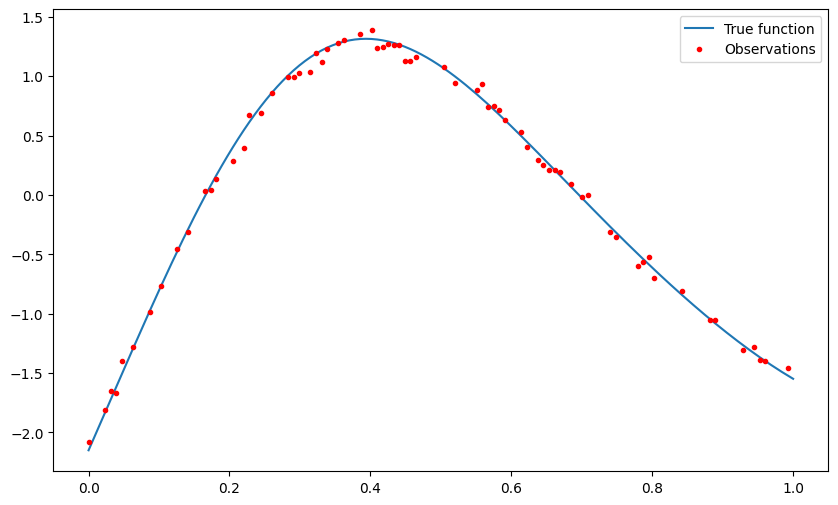

In [3]:
X = np.linspace(0, 1, 128)

for function_values, observations in synthetic_dataset:
    print(function_values)
    observation_values, observation_time_points = observations
    print(observation_time_points)
    print(observation_values)

    plt.figure(figsize=(10,6))
    plt.plot(X, function_values, label='True function')
    plt.plot(observation_time_points, observation_values, marker='.', color='red', linestyle='None', label='Observations')
    plt.legend()
    plt.show()
    break

In [4]:
def collate_fn_variable(batch):
    """
    Collate function for the synthetic dataset.
    Adds variable padding to each batch of the time series sequence.
    """
    # Unpack the batch into function values and observations
    function_values, observations = zip(*batch)
    
    # Convert function values to tensors (in case they’re numpy arrays)
    function_values = torch.stack([torch.tensor(f,dtype=torch.float32) for f in function_values])
    
    # Separate values and times in observations, and convert to tensors
    values, times = zip(*observations)
    values = [torch.tensor(v, dtype=torch.float32) for v in values]
    times = [torch.tensor(t, dtype=torch.float32) for t in times]
    
    # Pad values and times sequences to the length of the longest in the batch
    padded_values = pad_sequence(values, batch_first=True, padding_value=0)
    padded_times = pad_sequence(times, batch_first=True, padding_value=0)
    
    return function_values, (padded_values, padded_times)

In [5]:
def collate_fn_fixed(batch):
    """
    Collate function for the synthetic dataset.
    Pads each sequence in the batch to a fixed length of 128.
    """
    # Define the fixed length
    max_len = 128

    # Unpack the batch into function values and observations
    function_values, observations = zip(*batch)
    
    # Convert function values to tensors (in case they’re numpy arrays)
    function_values = torch.stack([torch.tensor(f, dtype=torch.float32) for f in function_values])
    
    # Separate values and times in observations, and convert to tensors
    values, times = zip(*observations)
    values = [torch.tensor(v, dtype=torch.float32) for v in values]
    times = [torch.tensor(t, dtype=torch.float32) for t in times]
    
    # Manually pad values and times sequences to a fixed length of 128
    padded_values = [F.pad(v, (0, max_len - len(v)), value=0) if len(v) < max_len else v[:max_len] for v in values]
    padded_times = [F.pad(t, (0, max_len - len(t)), value=0) if len(t) < max_len else t[:max_len] for t in times]
    
    # Stack the padded sequences into tensors
    padded_values = torch.stack(padded_values, dim=0)  # Shape: [batch, 128]
    padded_times = torch.stack(padded_times, dim=0)    # Shape: [batch, 128]
    
    return function_values, (padded_values, padded_times)

Only Transformer Encoder, Full Transformer would also require true function values shifted by one which goes against the specifications of the task. Maybe try only Transformer Decoder.

**DeepONet:**

takes two inputs [u(x1), u(x2), . . . , u(xm)] and y in our case u are the random functions and x the signals/observations. y are the points at which the output function is evaluated in our case that should be the points one the fine grid of 128 points. The network wants to learn an operator G in our case that would be the true underlying function.

 <img src="DeepONet.png"  style="width: 50%; height: auto;"/>
 
First there is a “trunk” network, which takes y as the input and outputs $[t_1, t_2, . . . , t_p]^T ∈ R^p$. We note that the trunk network also applies activation functions in the last layer, i.e., $t_k = σ(·)$ for $k = 1, 2, . . . , p$.<br>
A single branch network takes as input $[u(x_1), u(x_2), . . . , u(x_m)]^T$ and outputs a vector $[b_1, b_2, . . . , b_p]^T ∈ R^p$. Both outputs are merged together like:<br>

$G(u)(y) \approx \sum^p_{k=1} = b_k t_k$

Although bias is not necessary in Theorem 1, adding bias to the last layer of the branch network may increase the performance by reducing the generalization error

All versions of DeepONets are implemented in DeepXDE [15], a user-friendly Python library designed for scientific machine learning: https://github.com/lululxvi/deepxde

In [6]:
train_ratio = 0.8
validation_ratio = 0.2
dataset_size = len(synthetic_dataset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(synthetic_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn_fixed)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_fixed)

In [7]:
model = TimeSeriesTransformer().to(device)

for function_values, observations in train_loader:
    
    values, times = observations
    values, times = values.to(device), times.to(device)

    output = model(values, times)
    
    print(output.shape)
    break

torch.Size([64, 128])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
trunk = TrunkNetwork().to(device)
fine_grid_points = torch.tensor(X,dtype=torch.float32)
fine_grid_points_batch = torch.stack([fine_grid_points for _ in range(64)], dim=0)

trunk_output = trunk(fine_grid_points_batch.unsqueeze(-1).to(device))
trunk_output.shape

torch.Size([64, 128, 64])

In [9]:
X = np.linspace(0, 1, 128)
deeponet = DeepONet(X).to(device)

for function_values, observations in train_loader:
    
    values, times = observations
    values, times = values.to(device), times.to(device)

    output = deeponet(values, times)
    
    print(output.shape)
    break

torch.Size([64, 128])


In [ ]:
TBOARD_LOGS = os.path.join("./Arwin/src", "tboard_logs", "model_1.0")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS) 
writer = SummaryWriter(TBOARD_LOGS)

X = np.linspace(0, 1, 128)
deeponet = DeepONet(X).to(device)
criterion = nn.MSELoss()
trainer = Trainer(model=deeponet, criterion=criterion, train_loader=train_loader, valid_loader=validation_loader, modelname="model1.0", n_iters=2, writer=writer)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:223: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [11]:
trainer.fit()

Ep 0 Iter 1: Loss=1.09332:   0%|          | 0/1250 [00:00<?, ?it/s]

Valid loss @ iteration 0: Loss=1.1002334356307983


Ep 0 Iter 200: Loss=0.66875:  16%|█▌        | 200/1250 [01:38<08:32,  2.05it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:239: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Ep 0 Iter 251: Loss=0.59699:  20%|██        | 250/1250 [02:03<08:06,  2.06it/s]

Valid loss @ iteration 250: Loss=0.5481511950492859


Ep 0 Iter 501: Loss=0.25989:  40%|████      | 500/1250 [04:07<06:06,  2.05it/s]

Valid loss @ iteration 500: Loss=0.2558992803096771


Ep 0 Iter 751: Loss=0.21954:  60%|██████    | 750/1250 [06:12<04:08,  2.02it/s]

Valid loss @ iteration 750: Loss=0.19723212718963623


Ep 0 Iter 1001: Loss=0.18035:  80%|████████  | 1000/1250 [08:15<02:00,  2.07it/s]

Valid loss @ iteration 1000: Loss=0.17224614322185516


Ep 1 Iter 1: Loss=0.10894:   0%|          | 0/1250 [00:00<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.15653172135353088


Ep 1 Iter 251: Loss=0.17496:  20%|██        | 250/1250 [02:01<07:59,  2.08it/s]

Valid loss @ iteration 1500: Loss=0.14902475476264954


Ep 1 Iter 501: Loss=0.15107:  40%|████      | 500/1250 [04:02<05:57,  2.10it/s]

Valid loss @ iteration 1750: Loss=0.13985757529735565


Ep 1 Iter 751: Loss=0.12113:  60%|██████    | 750/1250 [06:02<03:57,  2.11it/s]

Valid loss @ iteration 2000: Loss=0.13263511657714844


Ep 1 Iter 1001: Loss=0.12279:  80%|████████  | 1000/1250 [08:02<01:58,  2.12it/s]

Valid loss @ iteration 2250: Loss=0.13183602690696716


Ep 1 Iter 1250: Loss=0.17508: 100%|█████████▉| 1249/1250 [10:04<00:00,  2.06it/s]


<Figure size 640x480 with 0 Axes>